In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
from jax import vmap
from jax.config import config
import equinox as eqx
import datasets
import operators
from losses import test_loss
import datasets
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
XLA_PYTHON_CLIENT_PREALLOCATE=False

mag_scale = 100

# Resolution of the solution
Nx = 100
Nt = 100

N_train = 2000 # number of input samples
m = Nx   # number of input sensors
P_train = 300 # number of output sensors, 100 for each side
Q_train = 100  # number of collocation points for each input sample


config.update("jax_enable_x64", True)

In [13]:
# Declare model 
model = operators.BHTDeepONet(branch_in_features=m, trunk_in_features=2, out_features=128, num_projection=128, nlayers=5)

In [8]:
# Declare model (for vanillaMLP)
# branch_layers = [m, 128, 128, 128, 128, 128]
# trunk_layers =  [2, 128, 128, 128, 128, 128]
# model = operators.vanillaDeepONet(branch_layers, trunk_layers)

branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = operators.vanillaDeepONet(branch_layers, trunk_layers)

In [64]:
params = model.get_params(model.opt_state)
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
param_count

145408

In [27]:
def load(filename):
    with open(filename, "rb") as f:
        model = BHTDeepONet.network(branch_in_features=m, trunk_in_features=2, out_features=100, num_projection=128)
        return eqx.tree_deserialise_leaves(f, model)


model_loaded = load("/home/aroy-admin/UT_Research/Operator_Learning/Operator_Learning/models/source+tumor_L5_NP128/model.eqx")

In [14]:
# Load the saved model
model_loaded = eqx.tree_deserialise_leaves(path_or_file="/home/aroy-admin/UT_Research/Operator_Learning/Operator_Learning/models_rerun/source+tumor_L5_NP128/model.eqx", like=model.opt_state)

In [76]:
# Testing one instance for visualization
inference_model = eqx.nn.inference_mode(model_loaded)
N_test = 100 # number of input samples
key = jr.PRNGKey(840)
P_test = 100
Nx = m
keys = jr.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(datasets.generate_one_test_data, (0, None, None))(keys, P_test, mag_scale)

u_test = jnp.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = jnp.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = jnp.float32(s_test.reshape(N_test * P_test**2,-1))

# Generate a uniform mesh
x = jnp.linspace(0, 1, Nx)
t = jnp.linspace(0, 1, Nt)
XX, TT = jnp.meshgrid(x, t)

params = model.get_params(inference_model)
s_pred = model.predict_s(params, u_test, y_test)
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')
S_error = S_test - S_pred

#Compute the Error
error_s = jnp.linalg.norm(S_test - S_pred) / jnp.linalg.norm(S_test)
print(error_s)

0.016263411203730885


In [6]:
S_pred.shape

(100, 100)

In [77]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
param_count

25600

In [5]:
def comparison_plots(key_):
    # Testing one instance for visualization
    inference_model = eqx.nn.inference_mode(model_loaded)
    N_test = 1 # number of input samples
    key = jr.PRNGKey(key_)
    P_test = 100
    Nx = m
    keys = jr.split(key, N_test)

    config.update("jax_enable_x64", True)
    u_test, y_test, s_test = vmap(datasets.generate_one_test_data, (0, None, None))(keys, P_test, mag_scale)

    u_test = jnp.float32(u_test.reshape(N_test * P_test**2,-1))
    y_test = jnp.float32(y_test.reshape(N_test * P_test**2,-1))
    s_test = jnp.float32(s_test.reshape(N_test * P_test**2,-1))

    # Generate a uniform mesh
    x = jnp.linspace(0, 1, Nx)
    t = jnp.linspace(0, 1, Nt)
    XX, TT = jnp.meshgrid(x, t)

    params = model.get_params(inference_model)
    s_pred = model.predict_s(params, u_test, y_test)
    S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
    S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')
    return S_pred, S_test

Minimum error data point:
Index: 32
Minimum Error: 0.0012001199634136274
Maximum error data point:
Index: 1
Maximum Error: 0.00543445983939223
Median error data point:
50% Median Error Index: 100
Median Error: 0.0018653812018096182


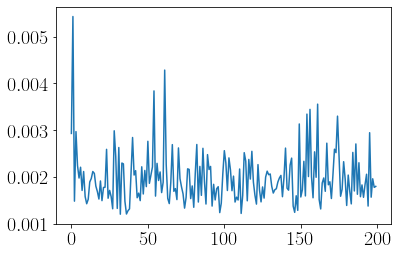

In [20]:
# Testing loss

inference_model = eqx.nn.inference_mode(model_loaded)

m = 100
N_test = 100 # number of input samples
key = jr.PRNGKey(20)
P_test = 100
Nx = m
Nt = m
keys = jr.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(datasets.generate_one_test_data, (0, None, None))(keys, P_test, mag_scale)

#Reshape Data
# u_test = np.float32(u_test.reshape(N_test * P_test**2 * 10,-1))
# y_test = np.float32(y_test.reshape(N_test * P_test**2 * 10,-1))
# s_test = np.float32(s_test.reshape(N_test * P_test**2 * 10,-1))

u_test = jnp.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = jnp.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = jnp.float32(s_test.reshape(N_test * P_test**2,-1))


params = model.get_params(inference_model)
x = jnp.linspace(0, 1, Nx)
t = jnp.linspace(0, 1, Nt)
XX, TT = jnp.meshgrid(x, t)

# Initialize variables to store minimum error and corresponding data
min_error = float('inf')  # Initialize with a large value
min_error_index = -1
min_error_S_test = None
min_error_S_pred = None

# Initialize variables to store maximum error and corresponding data
max_error = -float('inf')  # Initialize with a very small value
max_error_index = -1
max_error_S_test = None
max_error_S_pred = None



error_test = []
S_test_vals = []
S_pred_vals = []
for k in range(N_test):
    s_test_ = s_test[k*P_test**2:(k+1)*P_test**2,:]
    u_test_ = u_test[k*P_test**2:(k+1)*P_test**2,:]
    y_test_ = y_test[k*P_test**2:(k+1)*P_test**2,:]
    S_test = griddata(y_test_, s_test_.flatten(), (XX,TT), method='cubic')

    s_pred = model.predict_s(params, u_test_, y_test_)
    S_pred = griddata(y_test_, s_pred.flatten(), (XX,TT), method='cubic')
    error_s = jnp.linalg.norm(S_test - S_pred) / jnp.linalg.norm(S_test) 
    error_test.append(error_s)
    S_test_vals.append(S_test)
    S_pred_vals.append(S_pred)

    # Check if this error is the minimum found so far
    if error_s < min_error:
        min_error = error_s
        min_error_index = k
        min_error_S_test = S_test
        min_error_S_pred = S_pred

    if error_s > max_error:
        max_error = error_s
        max_error_index = k
        max_error_S_test = S_test
        max_error_S_pred = S_pred

# Sort the list of errors
error_test = jnp.array(error_test)
sorted_indices = jnp.argsort(error_test)
sorted_errors = error_test[sorted_indices]

# Find the median error
median_error = jnp.median(sorted_errors)

# Find the index corresponding to the 50% median error
median_index = jnp.searchsorted(sorted_errors, median_error)

# Retrieve corresponding S_test and S_pred values at the median index
median_S_test = S_test_vals[int(sorted_indices[median_index])]
median_S_pred = S_pred_vals[int(sorted_indices[median_index])]

testing_loss = jnp.stack(error_test)
plt.plot(testing_loss)
test_loss_mean = jnp.mean(testing_loss)

# After loop completes, min_error_S_test and min_error_S_pred will hold
# the S_test and S_pred values corresponding to the minimum error data point
print("Minimum error data point:")
print("Index:", min_error_index)
# print("S_test:", min_error_S_test)
# print("S_pred:", min_error_S_pred)
print("Minimum Error:", min_error)

print("Maximum error data point:")
print("Index:", max_error_index)
# print("S_test:", min_error_S_test)
# print("S_pred:", min_error_S_pred)
print("Maximum Error:", max_error)

print("Median error data point:")
print("50% Median Error Index:", median_index)
print("Median Error:", median_error)




In [21]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

fig = plt.figure(figsize=(15,15), dpi=600)

S_test_min = S_test_vals[min_error_index]
S_pred_min = S_pred_vals[min_error_index]

plt.subplot(4,3,1)
plt.pcolor(XX,TT, S_test_min, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Ground truth')
plt.tight_layout()

plt.subplot(4,3,2)
plt.pcolor(XX,TT, S_pred_min, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Prediction')
plt.tight_layout()

plt.subplot(4,3,3)
plt.pcolor(XX,TT, jnp.abs(S_pred_min - S_test_min), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()

S_test_median = S_test_vals[median_index]
S_pred_median = S_pred_vals[median_index]

plt.subplot(4,3,4)
plt.pcolor(XX,TT, S_test_median, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(4,3,5)
plt.pcolor(XX,TT, S_pred_median, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(4,3,6)
plt.pcolor(XX,TT, jnp.abs(S_pred_median - S_test_median), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

S_test_max = S_test_vals[max_error_index]
S_pred_max = S_pred_vals[max_error_index]

plt.subplot(4,3,7)
plt.pcolor(XX,TT, S_test_max, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(4,3,8)
plt.pcolor(XX,TT, S_pred_max, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(4,3,9)
plt.pcolor(XX,TT, jnp.abs(S_pred_max - S_test_max), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(4,3,10)
plt.plot(testing_loss*100)
plt.xlabel('Test samples')
plt.ylabel('Testing error percentage')
plt.tight_layout()

plt.subplot(4,3,12)
plt.hist(testing_loss*100, bins=50)
plt.xlabel('Testing error percentage')
plt.ylabel('Occurrences')
plt.tight_layout()
plt.savefig("4.png")
plt.show()

In [42]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

# Create a figure with specific size and DPI
fig = plt.figure(figsize=(15, 15), dpi=600)

# Define the subplot positions for the main plots
rows = 4
cols = 3

# Define the number of subplots per row and column
subplot_positions = {
    (0, 0): (S_test_min, 'Ground truth'),
    (0, 1): (S_pred_min, 'Prediction'),
    (0, 2): (jnp.abs(S_pred_min - S_test_min), 'Absolute error'),
    (1, 0): (S_test_median, 'Ground truth'),
    (1, 1): (S_pred_median, 'Prediction'),
    (1, 2): (jnp.abs(S_pred_median - S_test_median), 'Absolute error'),
    (2, 0): (S_test_max, 'Ground truth'),
    (2, 1): (S_pred_max, 'Prediction'),
    (2, 2): (jnp.abs(S_pred_max - S_test_max), 'Absolute error'),
    (3, 0): (testing_loss * 100, 'Testing error percentage'),
}

# Loop over the subplot positions and plot each subplot
for (row, col), (data, title) in subplot_positions.items():
    if row < rows - 1:  # For all subplots except the last row
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.pcolor(XX, TT, data, cmap='seismic')
        plt.colorbar()
        plt.xlabel('$x$')
        plt.ylabel('$t$')
        plt.title(title)
        plt.tight_layout()
    else:  # For the subplot in the last row (spanning all columns)
        plt.subplot(rows, cols, row * cols + 1)
        if isinstance(data, jnp.ndarray):  # Check if it's an array to plot
            plt.plot(data)
            plt.xlabel('Test samples')
            plt.ylabel(title)
        plt.tight_layout()

# Show the plot
plt.show()


In [13]:
# Plot

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

fig = plt.figure(figsize=(18,15), dpi=600)

S_pred, S_test = comparison_plots(45)
plt.subplot(3,3,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Ground truth')
plt.tight_layout()

plt.subplot(3,3,2)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Prediction')
plt.tight_layout()

plt.subplot(3,3,3)
plt.pcolor(XX,TT, jnp.abs(S_pred - S_test), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()

S_pred, S_test = comparison_plots(8)
plt.subplot(3,3,4)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(3,3,5)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(3,3,6)
plt.pcolor(XX,TT, jnp.abs(S_pred - S_test), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

S_pred, S_test = comparison_plots(84)
plt.subplot(3,3,7)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(3,3,8)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(3,3,9)
plt.pcolor(XX,TT, jnp.abs(S_pred - S_test), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.show()


In [10]:
# Plot (for poster only)

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 40})

fig = plt.figure(figsize=(18,18), dpi=600)

S_pred, S_test = comparison_plots(4655)
plt.subplot(2,2,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Ground truth')
plt.tight_layout()

plt.subplot(2,2,2)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Prediction')
plt.tight_layout()

S_pred, S_test = comparison_plots(8)
plt.subplot(2,2,3)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.subplot(2,2,4)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.tight_layout()

plt.show()
